# Sentiment Analysis for Brand Perception (Twitter)



* Analyze sentiment patterns: NLP techniques to perform sentiment analysis 
* Visualize sentiment trends:  informative data visualizations 
* Extract insights from the data:Dive deep into the sentiment analysis results to extract valuable insights


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
nltk.download('punkt')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\comp2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
col_names = ['ID', 'Entity', 'Sentiment', 'Content']

df = pd.read_csv('twitter_training.csv', names=col_names)
df.head()

,ID,Entity,Sentiment,Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Entity     74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [5]:
df.shape

(74682, 4)

In [6]:
df.dtypes

ID            int64
Entity       object
Sentiment    object
Content      object
dtype: object

In [7]:
df.isnull().sum()

ID             0
Entity         0
Sentiment      0
Content      686
dtype: int64

In [8]:
df.dropna(subset = ['Content'],inplace=True)

In [9]:
total_duplicates = df[df.duplicated(keep='first')].shape[0]

print("Total duplicate rows:", total_duplicates)

Total duplicate rows: 2340


In [10]:
df.drop_duplicates(keep='first', inplace=True)

df.reset_index(drop=True, inplace=True)

In [11]:
# replace irrelevant to neutral
df['Sentiment'] = df['Sentiment'].replace('Irrelevant', 'Neutral')

## EDA

#### Sentiment distribution

In [12]:
df.Sentiment.unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

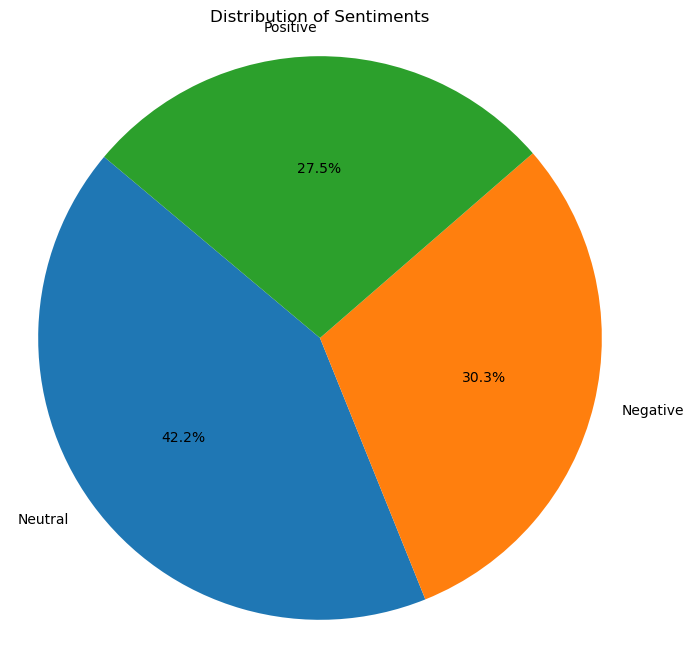

In [13]:

sentiment_distribution = df['Sentiment'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_distribution, labels=sentiment_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiments')
plt.axis('equal')  
plt.show()

#### Distribution of Entity

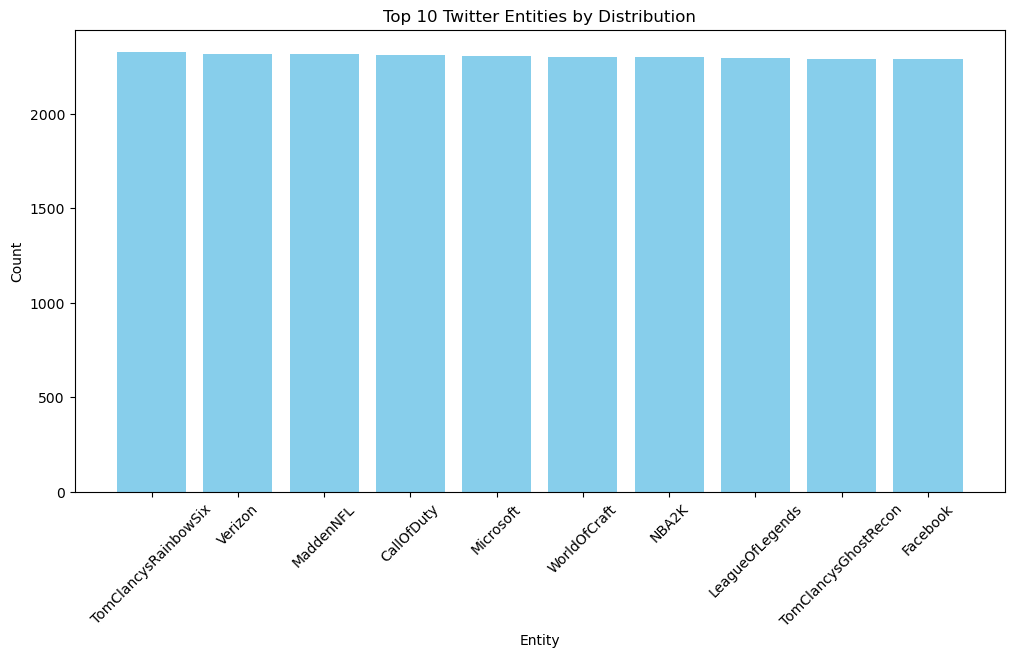

In [14]:
entity_distribution = df['Entity'].value_counts()

top_10_entities = entity_distribution.head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_10_entities.index, top_10_entities.values, color='skyblue')
plt.title('Top 10 Twitter Entities by Distribution')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### Sentiment Distribution in Top 3 Entities

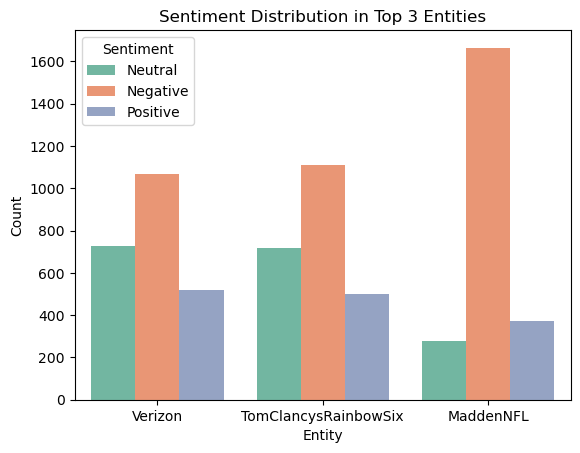

In [15]:
entity_distribution = df['Entity'].value_counts()

top_3_entities = entity_distribution.head(3).index

df_top_3 = df[df['Entity'].isin(top_3_entities)]

sns.countplot(data=df_top_3, x='Entity', hue='Sentiment', palette='Set2')
plt.title('Sentiment Distribution in Top 3 Entities')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.show()

#### Sentiment Distribution Analysis

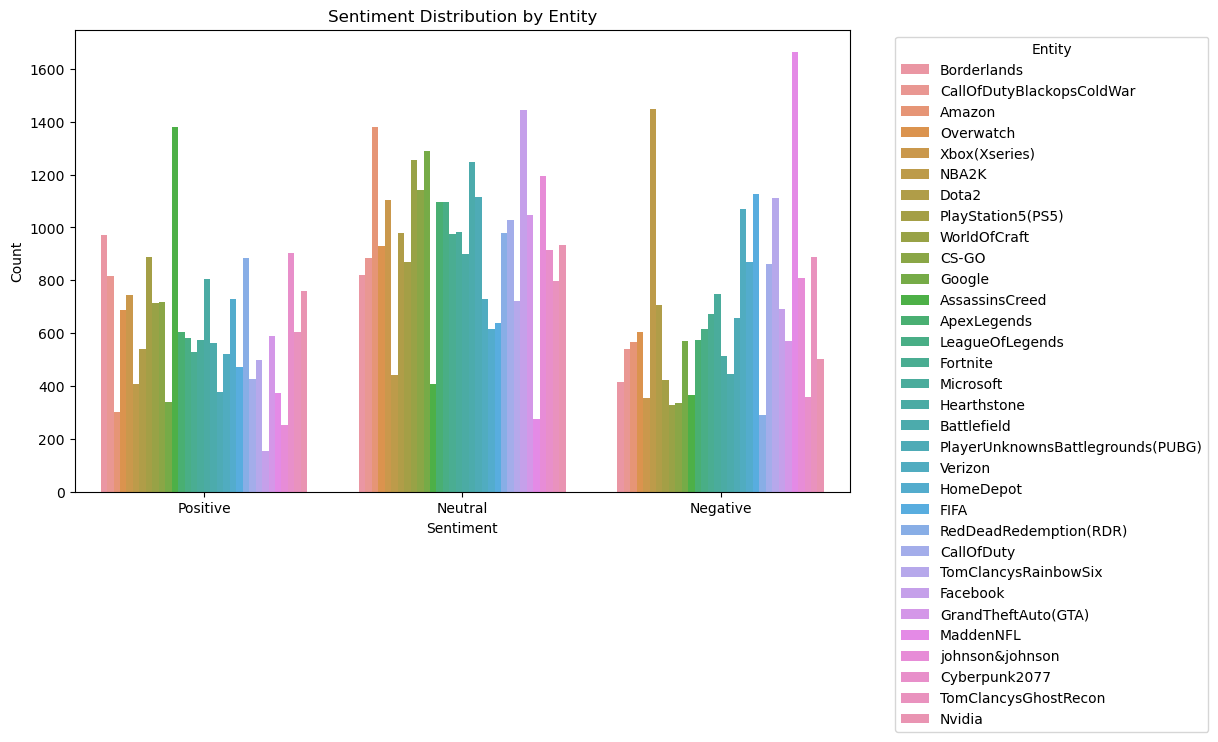

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Sentiment', hue='Entity')
plt.title("Sentiment Distribution by Entity")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.legend(title='Entity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Text Analysis with NLP Preprocessing

### NLP Preprocessing

The objective of this section is to perform NLP preprocessing on the text data in order to prepare it for further analysis

The code below will:
* Removed special characters, numbers, and links from the text.
* Converted text to lowercase.
* Tokenized the text into words.
* Removed stopwords  
* lemmatization

In [17]:
# lets Load NLTK stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))

# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text with lemmatization and stopwords removal
def preprocess_text(text):
    # Remove special characters, numbers, and links
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()  # Convert to lowercase
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

# Apply preprocessing with lemmatization and stopwords removal to the 'Content' column
df['Cleaned_Content'] = df['Content'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\comp2\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\comp2\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\comp2\AppData\Roaming\nltk_data...


### Sentiment Analysis

In [18]:
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

df['Sentiment_Score'] = df['Cleaned_Content'].apply(get_sentiment_scores)

def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment_Predicted'] = df['Sentiment_Score'].apply(categorize_sentiment)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\comp2\AppData\Roaming\nltk_data...


### Distribution of predicted sentiments

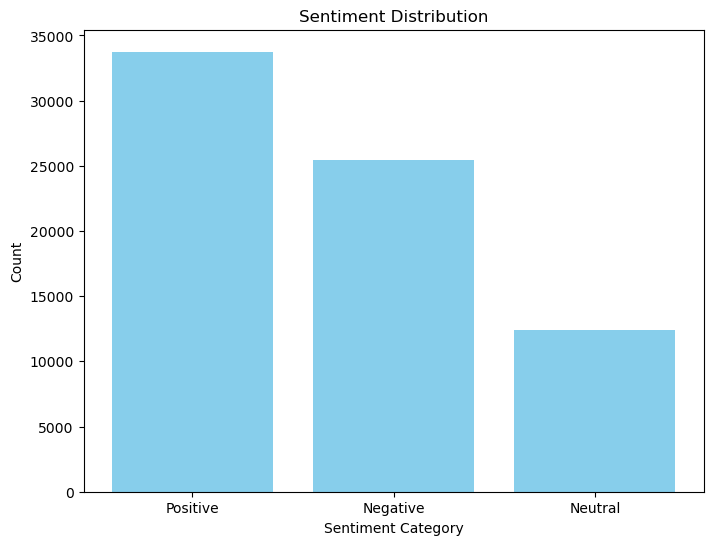

In [19]:
sentiment_distribution = df['Sentiment_Predicted'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(sentiment_distribution.index, sentiment_distribution.values, color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

#### Histogram of sentiment scores

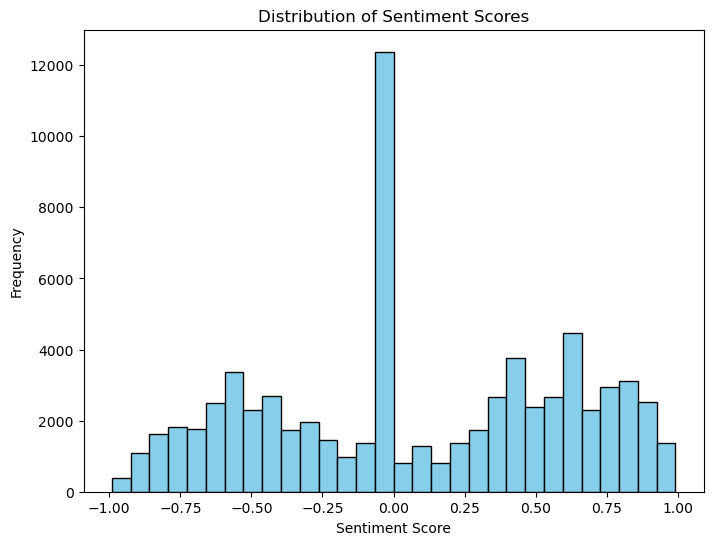

In [20]:
plt.figure(figsize=(8, 6))
plt.hist(df['Sentiment_Score'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

## Text Data Analysis

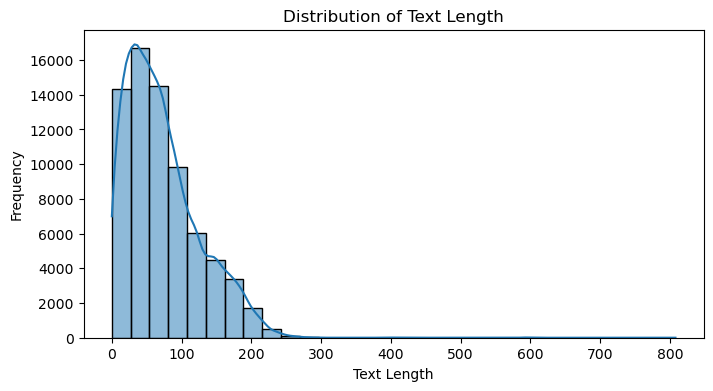

In [21]:
# for text length analysis
df['Text_Length'] = df['Cleaned_Content'].str.len()  # Calculate text length
plt.figure(figsize=(8, 4))
sns.histplot(df['Text_Length'], bins=30, kde=True)
plt.title("Distribution of Text Length")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

#### Word Frequency Analysis

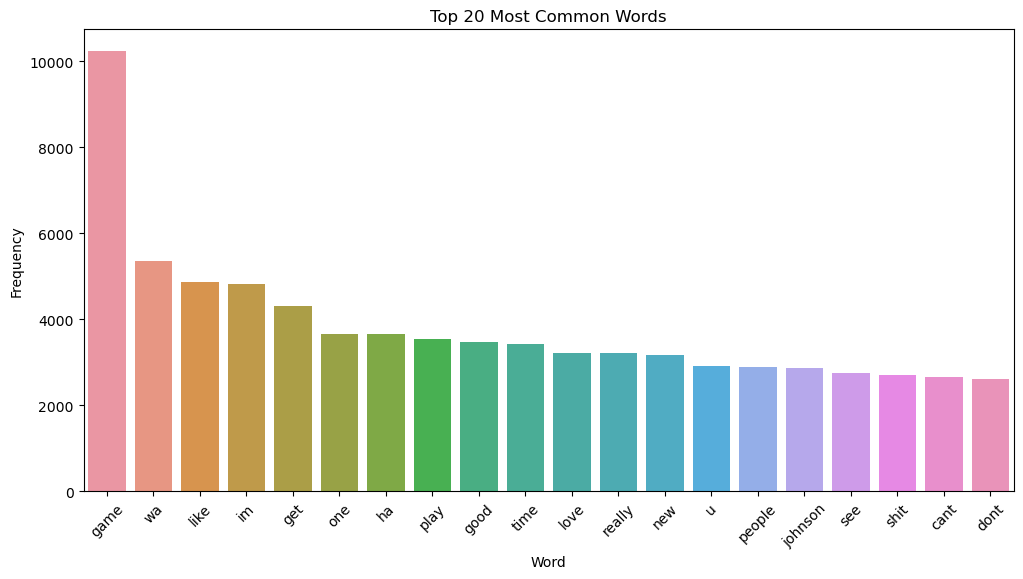

In [22]:
from collections import Counter

words = ' '.join(df['Cleaned_Content']).split()
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)

# Plot the top N most common words
plt.figure(figsize=(12, 6))
sns.barplot(x=[word[0] for word in most_common_words], y=[word[1] for word in most_common_words])
plt.title("Top 20 Most Common Words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


#### Word Cloud of Lemmatized Social Media Content

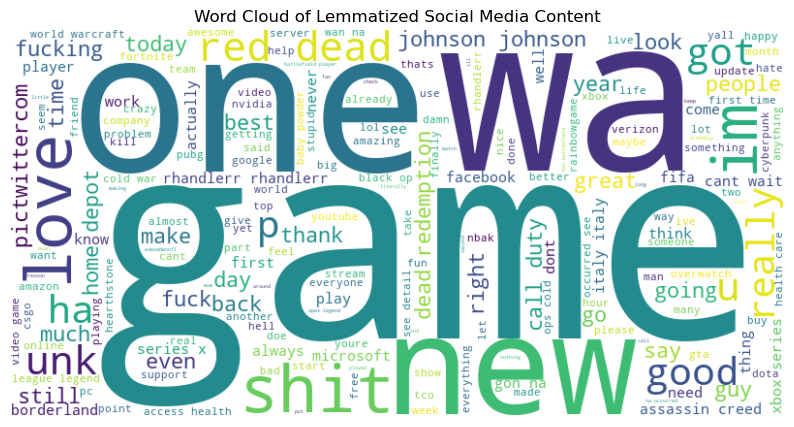

In [23]:
# Join the lemmatized content into a single string
text_data_lemmatized = ' '.join(df['Cleaned_Content'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data_lemmatized)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Lemmatized Social Media Content")
plt.show()


word cloud for text associated with positive sentiment

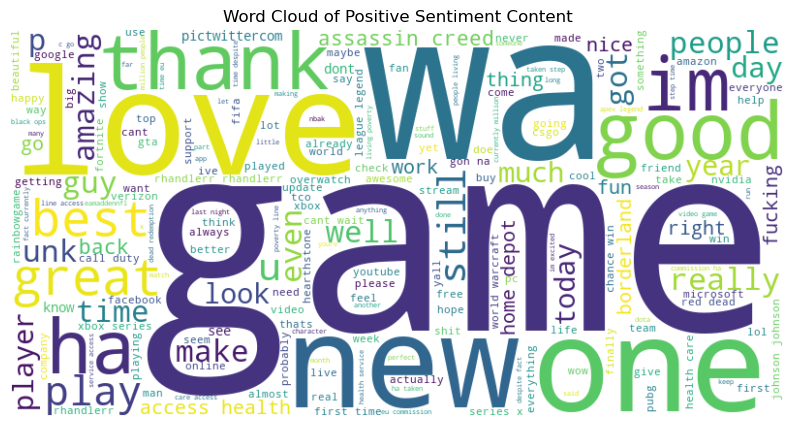

In [24]:
positive_data = df[df['Sentiment_Predicted'] == 'Positive']

positive_text_data = ' '.join(positive_data['Cleaned_Content'].dropna())

positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text_data)

plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Positive Sentiment Content")
plt.show()


#### Word Cloud for Negative Sentiment  


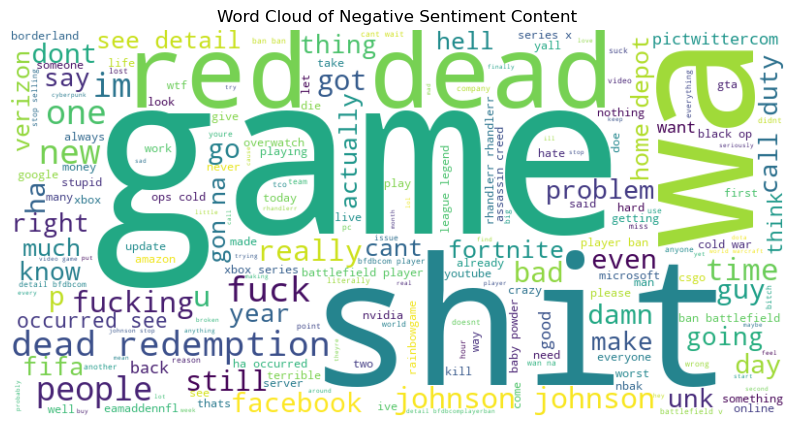

In [25]:
negative_data = df[df['Sentiment_Predicted'] == 'Negative']

negative_text_data = ' '.join(negative_data['Cleaned_Content'].dropna())

negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text_data)

plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Negative Sentiment Content")
plt.show()


#### Word Cloud for Neutral Sentiment

a word cloud for text associated with neutral sentiment

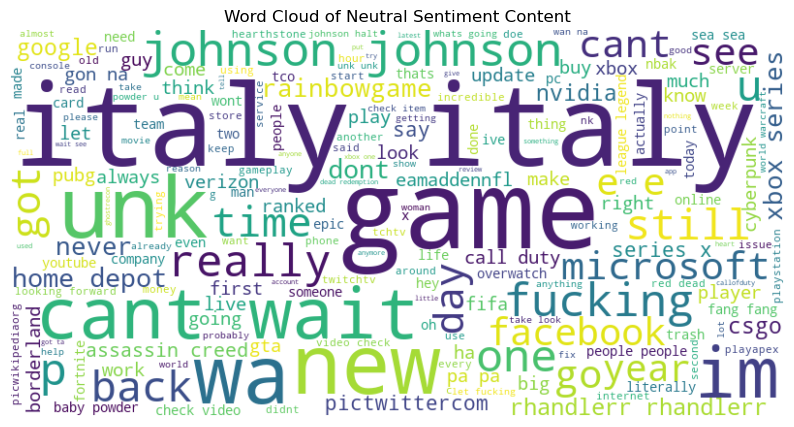

In [26]:
neutral_data = df[df['Sentiment_Predicted'] == 'Neutral']

neutral_text_data = ' '.join(neutral_data['Cleaned_Content'].dropna())

neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text_data)

plt.figure(figsize=(10, 6))
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Neutral Sentiment Content")
plt.show()


## MODELING

In [27]:
X = df['Cleaned_Content'] 
y = df['Sentiment_Predicted']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Feature Extraction (Vectorization)

convert text data into numerical features that can be used by machine learning algorithms using TF-IDF vectorization

In [28]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


### Model Training

In [29]:
model = LogisticRegression(max_iter=1000, solver='saga')

model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, solver='saga')

### Model Evaluation

In [30]:
y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9066424783700809
              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90      5066
     Neutral       0.89      0.85      0.87      2471
    Positive       0.92      0.93      0.93      6795

    accuracy                           0.91     14332
   macro avg       0.90      0.89      0.90     14332
weighted avg       0.91      0.91      0.91     14332



The sentiment analysis model showcased remarkable performance across three sentiment categories: Negative, Neutral, and Positive. Here's a concise overview of its performance:

- **Accuracy**: The model achieved  accuracy of approximately 91%
- **Precision**: Precision measures the accuracy of positive predictions. 
- **Recall (Sensitivity)**:  model's ability to identify actual positive instances.
- **F1-Score**: The F1-score, which balances precision and recall, ranged from 87% to 93% across sentiment categories.   
- **Macro and Weighted Averages** : Both macro and weighted averages were around 90% and 91%, respectively, indicating consistent performance across classes and considering class imbalance     
